## Introduction  
In this lab, we would like to make an XGBoost model to study the e-commerce behavior from a multi-category store. First, we need to download the data to your local machine, then we will load the data into a Pandas DataFrame.

## Objectives
- Apply XGBoost to an example

## Instruction
* Accept the Kaggle policy and download the data from [Kaggle](https://www.kaggle.com/code/tshephisho/ecommerce-behaviour-using-xgboost/data)
* For the first model you will only use the 2019-Nov csv data (which is still around ~2gb zipped)

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime

In [2]:
# fill this in with your path (absolute path works as well)
path_to_file = "./2019-Nov.csv"
df = pd.read_csv(path_to_file)

Start with some exploratory analysis. First, take a look at the first five rows of the DataFrame. Then get the information about the DataFrame, what is the shape of the DataFrame, and what are the coumn names?

In [3]:
# your code
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [4]:
# your code
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


In [5]:

df.shape# your code

(67501979, 9)

In [6]:
# your code
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

# Know your Customers
How many unique customers visit the site? Assign the number of visitors to the visitor variable and print it out

In [7]:
# your code
visitors = df.user_id.nunique()
visitors

3696117

# Visitors Daily Trend
Does traffic fluctuate by date? Try using the `event_time` and `user_id` to see traffic. First you need to select by `event_time` and `user_id`, then you will `drop_duplicates` and `groupby` `event_time` and `user_id`.

In [8]:
d = df.loc[:, ["event_time", "user_id"]]
d["event_time"] = d["event_time"].apply(lambda s: str(s)[0:10])
visitor_by_date = (
    d.drop_duplicates()
    .groupby(["event_time"])["user_id"]
    .agg(["count"])
    .sort_values(by=["event_time"], ascending=True)
)
x = pd.Series(visitor_by_date.index.values).apply(
    lambda s: datetime.strptime(s, "%Y-%m-%d").date()
)
y = visitor_by_date["count"]

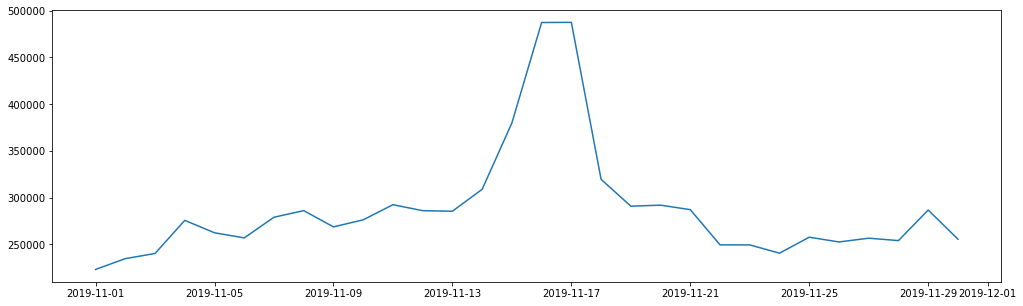

In [9]:
plt.rcParams["figure.figsize"] = (17, 5)
plt.plot(np.array(x), np.array(y))
plt.show()

### By Category and Product
Which category do customers interact with the most? What brand do they view the most? You can choose just the categories with at least 30 records in order to construct the plots.

In [10]:
max_category_num = 30
top_category = (
    df.loc[:, "category_code"]
    .value_counts()[:max_category_num]
    .sort_values(ascending=False)
)

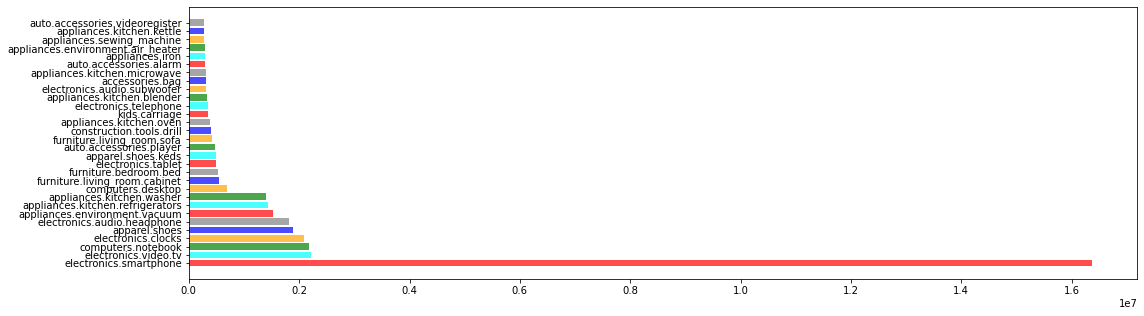

In [11]:
plt.barh(
    width=top_category,
    y=top_category.index.array,
    color=["red", "cyan", "green", "orange", "blue", "grey"],
    alpha=0.7,
)

plt.show()

## Purchases

When the event_type is "purchase", what item do customers buy?

Try using `'event_type' == 'purchase'` and drop empty rows to assess which categories customers buy.

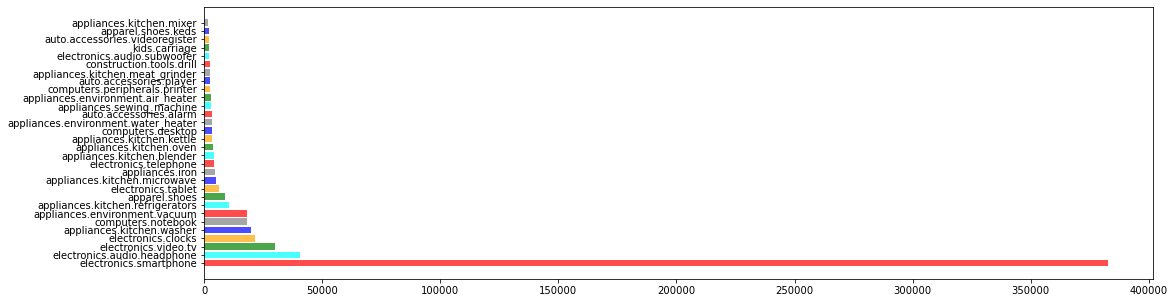

In [12]:
# your code
purchases = df.loc[df['event_type'] == 'purchase']
purchases = purchases.dropna()
max_category_num = 30
top_category_purchases = (
    purchases.loc[:, "category_code"]
    .value_counts()[:max_category_num]
    .sort_values(ascending=False)
)

plt.barh(
    width=top_category_purchases,
    y=top_category_purchases.index.array,
    color=["red", "cyan", "green", "orange", "blue", "grey"],
    alpha=0.7,
)

plt.show()

## What brands do the customers buy?
Try grouping by brand and sorting the values by the brand name.

In [13]:
# your code
top_sellers = (
    purchases.groupby("brand")["brand"]
    .agg(["count"])
    .sort_values("count", ascending=False)
)
top_sellers.head(20)

,count
brand,
samsung,198670
apple,165681
xiaomi,57909
huawei,23466
oppo,15080
lg,11828
artel,7269
lenovo,6546
acer,6402


In [14]:
del d  # free memory

# Modeling: predict at the time of addition to a shopping cart if the user will purchase a given product or not

### Feature engineering

The goal of this modeling is to predict if the user will purchase a product or not when they add the product to the cart. This is called `cart abandonment` if the user does not purchase.

First, reconstruct and restructure the data to feed into the machine learning model. For this use case, target only the data for which customers have "put" the product into the cart. The relevant `event_type`s are thus "cart" and "purchase".

Create these new features in the training data set:
- `activity_count`: number of activity in that session
- `category_level1`: category
- `category_level2`: sub-category --> split on the "." in the category name
- `weekday`: weekday of the event --> convert `event_time` to a datetime object, then use `pandas.Timestamp.weekday`
- `is_purchased`: whether the is purchased after being put in the cart, this will be the categorical output.

Make sure to de-dup any record.

**Prepare a dataframe for counting activity in the session**

In [15]:
# your code
# first just eliminate the records where event_type = "view" and drop NA values and duplicates
df_targets = df.loc[df['event_type'] != 'view']
df_targets.drop_duplicates(subset = ["event_type", "product_id", "price", "user_id", "user_session"], inplace = True)
df_targets.dropna(inplace = True)
df_targets.info()

<ipython-input-15-2cf3f77f1932>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets.drop_duplicates(subset = ["event_type", "product_id", "price", "user_id", "user_session"], inplace = True)


<class 'pandas.core.frame.DataFrame'>
Index: 2031788 entries, 40 to 67501863
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 155.0+ MB


<ipython-input-15-2cf3f77f1932>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets.dropna(inplace = True)


In [16]:
cart_purchase_users = df.loc[
    df["event_type"].isin(["cart", "purchase"])
].drop_duplicates(subset=["user_id"])
cart_purchase_users.dropna(how="any", inplace=True)
cart_purchase_users_all_activity = df.loc[
    df["user_id"].isin(cart_purchase_users["user_id"])
]

In [17]:
# now you get the number of activities by user session

activity_in_session = (
    cart_purchase_users_all_activity.groupby(["user_session"])["event_type"]
    .count()
    .reset_index()
)
activity_in_session = activity_in_session.rename(
    columns={"event_type": "activity_count"}
)
df_targets = cart_purchase_users_all_activity.copy()

In [18]:
# create the two new columns for the category levels 1 and 2
# your code here
df_targets['category_level1'] = df_targets['category_code'].str.split(".",expand = True)[0].astype("category")
df_targets['category_level2'] = df_targets['category_code'].str.split(".",expand = True)[1].astype("category")
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_level1,category_level2
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,NaN,NaN
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,appliances,kitchen
9,2019-11-01 00:00:02 UTC,view,1004258,2053013555631882655,electronics.smartphone,apple,732.07,532647354,d2d3d2c6-631d-489e-9fb5-06f340b85be0,electronics,smartphone
14,2019-11-01 00:00:05 UTC,view,4600658,2053013563944993659,appliances.kitchen.dishwasher,samsung,411.83,526595547,aab33a9a-29c3-4d50-84c1-8a2bc9256104,appliances,kitchen
26,2019-11-01 00:00:09 UTC,view,17501048,2053013558752445019,NaN,eveline,7.59,515849878,31e80b9c-e5b3-437b-9112-c2a110e5c38a,NaN,NaN


In [19]:
# Change the event_time to a timestamp
# your code
df_targets["timestamp"] = pd.to_datetime(df_targets["event_time"])

In [20]:
# Use pandas.dt.dayofweek to get the day of the week
# your code
df_targets["day_of_week"] = df_targets["timestamp"].dt.dayofweek

In [21]:
# add the is_purchased feature
# your code
df_targets["is_purchased"] = np.where(df_targets["event_type"] == "purchase", 1, 0)
df_targets["is_purchased"] = df_targets.groupby(["user_session", "product_id"])[
    "is_purchased"
].transform("max")

In [22]:
df_targets = df_targets.merge(activity_in_session, on="user_session", how="left")
df_targets["activity_count"] = df_targets["activity_count"].fillna(0)
df_targets["brand"] = df_targets["brand"].astype("object")
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_level1,category_level2,timestamp,day_of_week,is_purchased,activity_count
0,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,NaN,NaN,2019-11-01 00:00:01+00:00,4,0.0,11.0
1,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,appliances,kitchen,2019-11-01 00:00:01+00:00,4,0.0,1.0
2,2019-11-01 00:00:02 UTC,view,1004258,2053013555631882655,electronics.smartphone,apple,732.07,532647354,d2d3d2c6-631d-489e-9fb5-06f340b85be0,electronics,smartphone,2019-11-01 00:00:02+00:00,4,0.0,9.0
3,2019-11-01 00:00:05 UTC,view,4600658,2053013563944993659,appliances.kitchen.dishwasher,samsung,411.83,526595547,aab33a9a-29c3-4d50-84c1-8a2bc9256104,appliances,kitchen,2019-11-01 00:00:05+00:00,4,0.0,9.0
4,2019-11-01 00:00:09 UTC,view,17501048,2053013558752445019,NaN,eveline,7.59,515849878,31e80b9c-e5b3-437b-9112-c2a110e5c38a,NaN,NaN,2019-11-01 00:00:09+00:00,4,0.0,7.0


### Save new data structure if desired

In [23]:
# df_targets.to_csv('training_data.csv')
df_targets.dropna(inplace=True)

In [24]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20983602 entries, 1 to 26749089
Data columns (total 15 columns):
 #   Column           Dtype              
---  ------           -----              
 0   event_time       object             
 1   event_type       object             
 2   product_id       int64              
 3   category_id      int64              
 4   category_code    object             
 5   brand            object             
 6   price            float64            
 7   user_id          int64              
 8   user_session     object             
 9   category_level1  category           
 10  category_level2  category           
 11  timestamp        datetime64[ns, UTC]
 12  day_of_week      int32              
 13  is_purchased     float64            
 14  activity_count   float64            
dtypes: category(2), datetime64[ns, UTC](1), float64(3), int32(1), int64(3), object(5)
memory usage: 2.1+ GB


In [25]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

## Resampling training set

In [26]:
is_purcahase_set = df_targets[df_targets["is_purchased"] == 1]
is_purcahase_set.shape[0]

2701965

In [27]:
not_purcahase_set = df_targets[df_targets["is_purchased"] == 0]
not_purcahase_set.shape[0]

18281637

In [28]:
n_samples = 500000
is_purchase_downsampled = resample(
    is_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)
not_purcahase_set_downsampled = resample(
    not_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)

In [37]:
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled["is_purchased"].value_counts()
downsampled['brand'] = downsampled['brand'].astype("category")
downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 22500018 to 13442419
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   event_time       1000000 non-null  object             
 1   event_type       1000000 non-null  object             
 2   product_id       1000000 non-null  int64              
 3   category_id      1000000 non-null  int64              
 4   category_code    1000000 non-null  object             
 5   brand            1000000 non-null  category           
 6   price            1000000 non-null  float64            
 7   user_id          1000000 non-null  int64              
 8   user_session     1000000 non-null  object             
 9   category_level1  1000000 non-null  category           
 10  category_level2  1000000 non-null  category           
 11  timestamp        1000000 non-null  datetime64[ns, UTC]
 12  day_of_week      1000000 non-null  int3

In [38]:
# select the brand, price, weekday, category_level1, cateogry_level2, and activity_count features

features = downsampled[["brand",
        "price",
        "day_of_week",
        "category_level1",
        "category_level2",
        "activity_count",]]
features
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 22500018 to 13442419
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   brand            1000000 non-null  category
 1   price            1000000 non-null  float64 
 2   day_of_week      1000000 non-null  int32   
 3   category_level1  1000000 non-null  category
 4   category_level2  1000000 non-null  category
 5   activity_count   1000000 non-null  float64 
dtypes: category(3), float64(2), int32(1)
memory usage: 30.6 MB


In [39]:
df.brand.value_counts()

brand
samsung       7889245
apple         6259379
xiaomi        4638062
huawei        1410126
lucente       1185075
               ...   
alfa                1
motorcraft          1
pervenec            1
interlink           1
osprey              1
Name: count, Length: 4200, dtype: int64

## Encode categorical variables

In [40]:
features.loc[:, "brand"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "brand"].copy()
)
features.loc[:, "day_of_week"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "day_of_week"].copy()
)
features.loc[:, "category_level1"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_level1"].copy()
)
features.loc[:, "category_level2"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_level2"].copy()
)

is_purchased = LabelEncoder().fit_transform(downsampled["is_purchased"])
features.head()

,brand,price,day_of_week,category_level1,category_level2,activity_count
22500018,83,1003.37,5,7,40,7.0
2685089,650,231.19,2,7,40,8.0
26205183,818,231.64,5,4,29,4.0
14226883,1388,226.49,5,2,18,6.0
1697705,1223,321.73,0,2,26,15.0


In [41]:
print(list(features.columns))

['brand', 'price', 'day_of_week', 'category_level1', 'category_level2', 'activity_count']


## Split the data
Use a test size of 0.3 and a random state of 86 to split the data into test and train subsets

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, is_purchased, test_size = 0.3, random_state = 86)

## Train the model
Choose learning rate of 0.1 on XGBClassifier, fit the model, and make predictions on the test set

In [56]:
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate = .1)
# fit the model on the train sets
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [57]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("fbeta:", metrics.fbeta_score(y_test, y_pred, average="weighted", beta=0.5))

Accuracy: 0.6963066666666666
Precision: 0.6805461963513397
Recall: 0.7403500119958415
fbeta: 0.6966536538237529


## Feature importance
Plot the feature importance using plot_importance

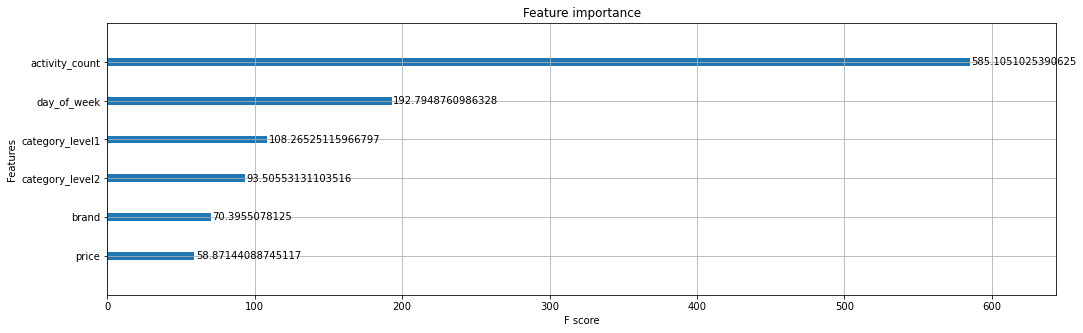

In [58]:
plot_importance(model, max_num_features=10, importance_type="gain")
# plt.rcParams['figure.figsize'] = (40,10)
plt.show()